In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import itertools
from skimage.measure import compare_ssim as ssim

Using TensorFlow backend.


## Loading data

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

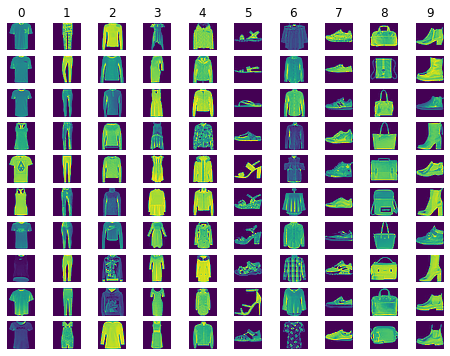

In [3]:
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = 10
samples = 10

plt.figure(figsize = (8,6))

for y, cls in enumerate(classes):
    indices = np.nonzero([i == y for i in y_train])
    indices = np.random.choice(indices[0], samples, replace=False)
    for i , index in enumerate(indices):
        plt_index = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_index)
        plt.axis('off')
        plt.imshow(X_train[index].reshape((28, 28)))
        if i == 0:
            plt.title(cls)

plt.show()

## Data Pre-processing

In [4]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [5]:
# reshuffle data
y_train = np.reshape(y_train, (-1, 1))
data_set = np.append(X_train, y_train, axis=1)
np.random.shuffle(data_set)
X_train = np.delete(data_set, 784, 1)
y_train = np.delete(data_set, np.s_[:784], 1)
y_train = y_train.flatten()

## Comparing images using Mean Square Error (MSE)

In [6]:
# By observation label 6 and label 0, 2 ,4 looks a lot in common
# Using mse to compare the similarity of the images for different labels

def compare_images(img1, img2, method='mse'):
    # using MSE
    err = np.sum((img1.astype('float') - img2.astype('float')) ** 2)
    err /= float(img1.shape[0])
    return err

In [7]:
# Grouping indices for different labels into a index list
group_indices = []
for i in range(num_classes):
    group_indices.append(np.nonzero([label == i for label in y_train]))

# Compute average mse
def compute_avg_metric(label_a, label_b, n_imgs):
    metric_list = []
    for img_a in X_train[group_indices[label_a]][0:n_imgs]:
        metric_temp = []
        for img_b in X_train[group_indices[label_b]][0:n_imgs]:
            metric_temp.append(compare_images(img_a, img_b))
        metric_list.append(np.mean(metric_temp))
    return np.mean(metric_list)

# Compute similarity for n images
def similarity(label_a, n_imgs):
    s_list = []
    for i in classes:
        if i is not label_a:
            # print('Similarity compared with label {} is {:.2f}'.format(i, compute_avg_norm(label_a, i, n_imgs)))
            s_list.append(compute_avg_metric(label_a, i, n_imgs))
        else:
            s_list.append(0)
    return s_list

## Creating a similarity matrix using random 100 images from each label

In [8]:
num_images = 100
s_matrix = []
for m in range(num_classes):
    s_matrix.append(similarity(m, num_images))
s_matrix = np.array(s_matrix)

## Visulising the similarity with a similarity matrix

In [9]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.bwr):
    plt.figure(figsize = (8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes))
    y_tick_marks = np.arange(-0.5, len(classes))
    plt.xticks(x_tick_marks, classes)
    plt.yticks(y_tick_marks, classes)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'), ha ='center', va ='center', color='white')
    
    plt.ylabel('Label')
    plt.xlabel('Label')
    plt.tight_layout()

In [10]:
# Replace 0 with max value to improve visulisation
def replace_zero(m):
    return np.where(m == 0, m.max(), m)

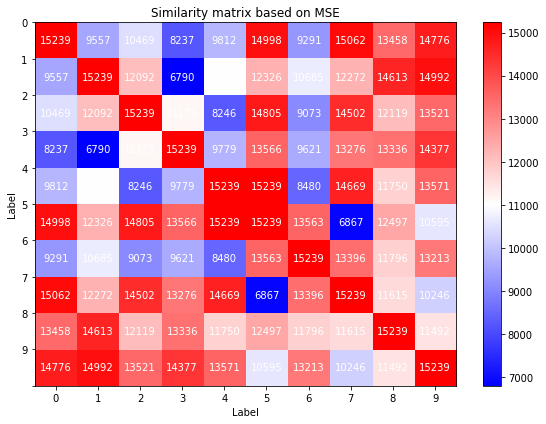

In [11]:
# The lower the value, the more similar images from a pair of labels are
# Labels with color towards blue are potentially more vulnerable to misclassification
# Labels with color towards red are potentially less vulnerable to misclassification
# Noted the avg MSE is computed with a small number of images and can be biased
# This is largely due to limited computing power as larger sample requires longer computing time

plot_confusion_matrix(replace_zero(s_matrix), classes=list(set(y_test)),
                      title='Similarity matrix based on MSE')